In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00


In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

In [ ]:
# https://archive.ics.uci.edu/dataset/1/abalone

In [3]:
#import dataset
data = pd.read_csv("/content/abalone.data")
data.head()


,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


In [4]:
data = pd.read_csv("/content/abalone.data",
                   names=["sex","length","diameter","height",
                         "whole weight","shucked weight",
                         "viscera weight","shell weight",
                         "rings"])
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Text(0.5, 0, 'whole weight')

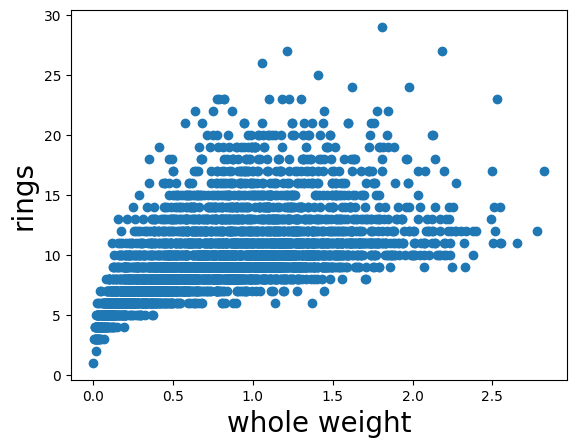

In [6]:
# plot 1: whole weight
plt.scatter(data["whole weight"], data["rings"])
plt.ylabel("rings", size=20)
plt.xlabel("whole weight", size=20)

In the charts above, we visualise the relationships of some of the features and the target variable. Shucked weight is the weight of the abalone meat (i.e. once it has been removed from the shell). We can see that the number of rings tends to increase as the shucked weight increases. This makes sense, as we would expect older abalone to be bigger and have more meat.

Text(0.5, 0, 'sex')

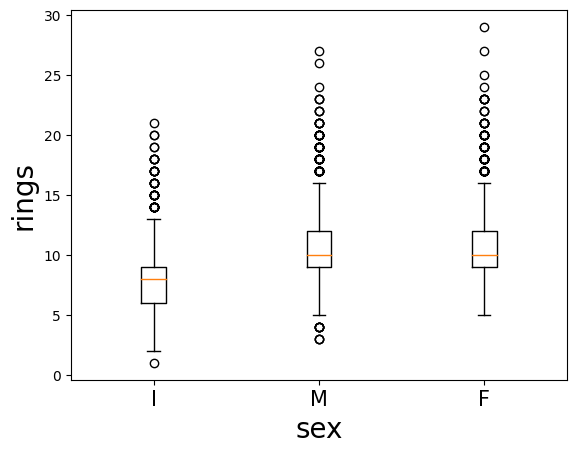

In [7]:
# plot 2: sex
plt.boxplot(data[data.sex == "I"]["rings"], positions=[1])
plt.boxplot(data[data.sex == "M"]["rings"], positions=[2])
plt.boxplot(data[data.sex == "F"]["rings"], positions=[3])

plt.xticks(ticks=[1, 2, 3], labels=["I", "M", "F"], size=15)
plt.ylabel("rings", size=20)
plt.xlabel("sex", size=20)

"Sex" variable has three categories(F, M, I) so we transfom it into 3 dummy variables.

<Axes: >

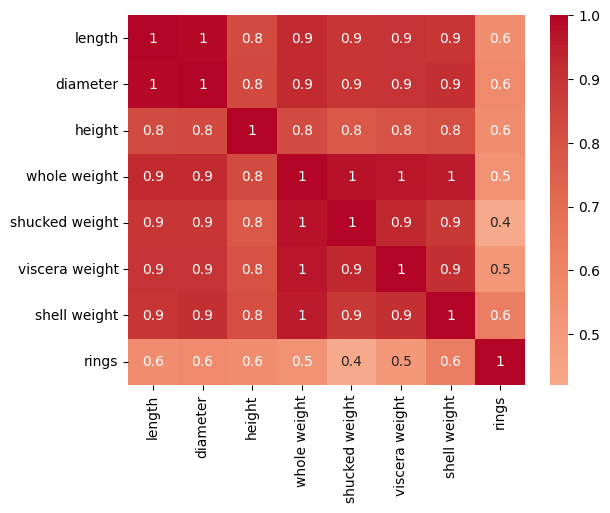

In [9]:
# plot 3: Correlation heatmap
import seaborn as sns
cont = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

Correlation matrix for the continuous features. You can see that we are dealing with highly correlated features. Length and diameter are perfectly correlated. Similarly, whole weight is highly correlated with the other weight measurements. Such as the weight of the meat (shucked weight) and the weight of the shell excluding the meat (shell weight).

In [10]:
#Get features
y = data['rings']
X = data[["sex","length","height",
          "shucked weight","viscera weight","shell weight"]]

In [11]:
#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

<ipython-input-11-d9d2b0e84184>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
<ipython-input-11-d9d2b0e84184>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]


In [12]:
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


In [13]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

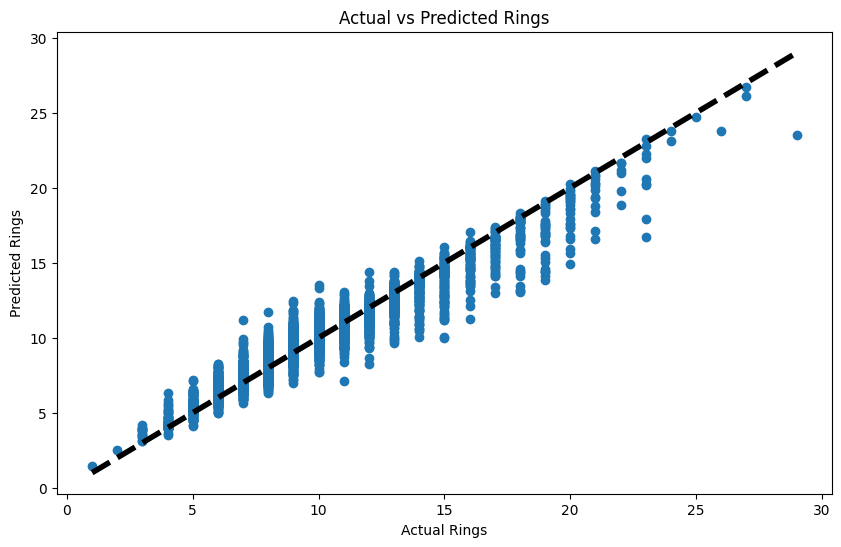

In [14]:
# Get prediction
y_pred = model.predict(X)

# Model Evaluation
plt.figure(figsize=(10,6))
plt.scatter(y, y_pred)

plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=4)

plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")
plt.title("Actual vs Predicted Rings")
plt.show()


# SHAP Plots
We can interpret this model using SHAP values. To do this, we pass our model into the SHAP Explainer function.This creates an explainer object. We use this to calculate SHAP values for every observation in the feature matrix.

In [15]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [16]:
shap_values[0]

.values =
array([ 0.36806285,  1.0587054 ,  0.94834965, -0.05403227, -0.43605894,
        0.3316413 , -0.04919233,  0.3216473 ], dtype=float32)

.base_values =
9.93266

.data =
array([0.455 , 0.095 , 0.2245, 0.101 , 0.15  , 1.    , 0.    , 0.    ])

## Plot 1: Waterfall
There are 8 SHAP values for each of the 4,177 observations in the feature matrix. That is one SHAP value for each feature in our model. We can use the waterfall function to visualise the SHAP values of the first observation

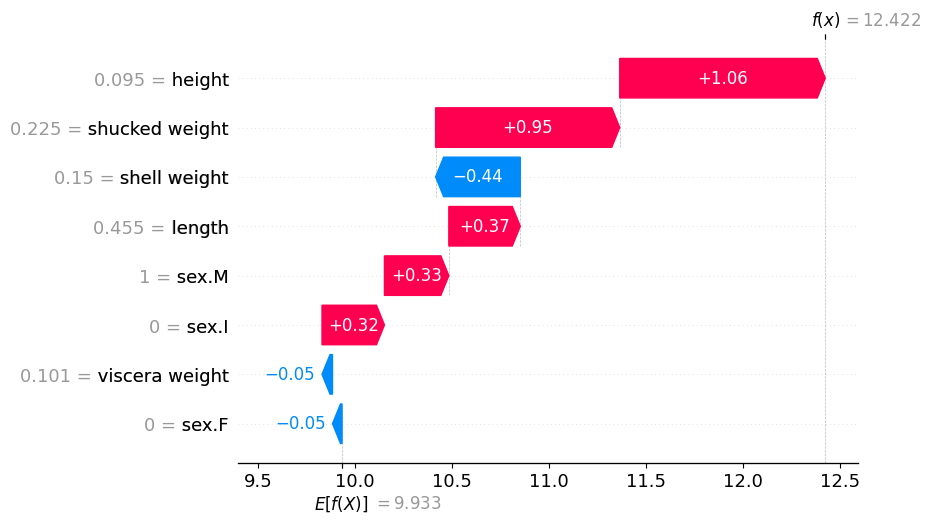

In [17]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

***E[f(x)] = 9.933*** gives the average predicted number of rings across all 4,177 abalones. ***f(x) = 12.422*** is the predicted number of rings for this particular abalone. The SHAP values are all the values in between. For example, the shucked weight has increased the predicted number of rings by 0.95

There will be a unique waterfall plot for every observation/abalone in our dataset. They can all be interpreted in the same way as above. In each case, the SHAP values tell us how the features have contributed to the prediction when compared to the mean prediction. Large positive/negative values indicate that the feature had a significant impact on the model’s prediction.

## Plot 2: Force Plot
Another way to visualise these is using a force plot. You can think of this as a condensed waterfall plot. We start at the same base value of 9.933 and you can see how each feature has contributed to the final prediction of 12.42.

In [18]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[0])

## Plot 3: Stacked force plot
Waterfall and force plots are great for interpreting individual predictions. To understand how our model makes predictions in general we need to aggregate the SHAP values. One way to do this is by using a stacked-force plot

We can combine multiple force plots together to create a stacked force plot. Here we pass the SHAP values for the first 100 observations in the force plot function. Each individual force plot is now vertical and stacked side by side.

In [19]:
shap.initjs()
shap.plots.force(shap_values[0:100])

For example, in the plot below we have:

Only displayed the SHAP values for shell weight `(y-axis = shell weight effects)`
Ordered the force plots by the shell weight feature values `(x-axis = shell weight)`
- From this plot, we can see that as shell weight increases the SHAP values also increase. In other words, older abalones tend to have heavier shells.<br>
<br>
This is one way to understand the nature of the relationships captured by our model. We will see that the beeswarm plot and dependence plots can also be used in this way.

## Plot 4: Mean SHAP
This next plot will tell us which features are most important. For each feature, we calculate the mean SHAP value across all observations. Specifically, we take the mean of the absolute values as we do not want positive and negative values to offset each other. In the end, we have the bar plot below. There is one bar for each feature. For example, we can see that shell weight had the largest mean SHAP value.

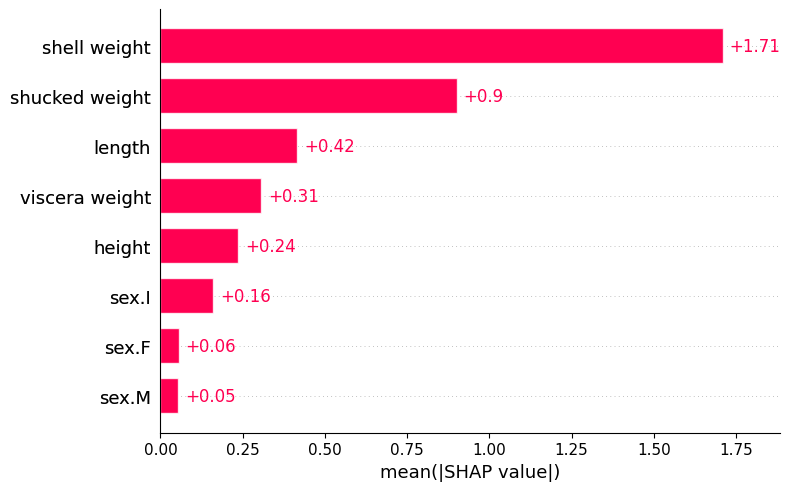

In [20]:
#Mean SHAP
shap.initjs()
shap.plots.bar(shap_values)

Features that have made large positive/negative contributions will have a large mean SHAP value. In other words, these are the features that have had a significant impact on the model’s predictions. In this sense, this plot can be used in the same way as a feature importance plot.

## Plot 5: Beeswarm
Next, we have the single most useful plot. The beeswarm visualises all of the SHAP values. On the y-axis, the values are grouped by feature. For each group, the colour of the points is determined by the feature value (i.e. higher feature values are redder).

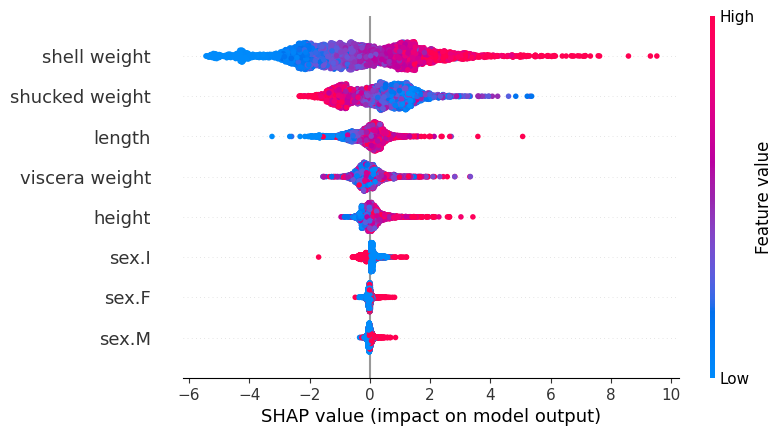

In [21]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

- Like mean SHAP, the beeswarm can be used to highlight important relationships. In fact, the features in the above plot are ordered by mean SHAP.
- We can also start to understand the nature of these relationships. For shell weight, notice how as the feature value increases the SHAP values increase. We saw a similar relationship in the stacked force plot. It tells us that larger values for shell weight will lead to a higher predicted number of rings.
- You may have noticed that shucked weight has the opposite relationship. Looking at the beeswarm plot, we can see that larger values for this feature are associated with smaller SHAP values. We can take a closer look at these relationships using dependence plots.

## Plot 6: Dependence plots
A dependence plot is a scatter plot of the SHAP value vs feature value for a single feature. They are particularly useful if the feature has a non-linear relationship with the target variable.

For example, take the dependence plot for shell weight. Looking at the beeswarm plot we may have assumed that the SHAP values increase linearly with the feature value. The dependency plot tells us that the relationship is not perfectly linear.

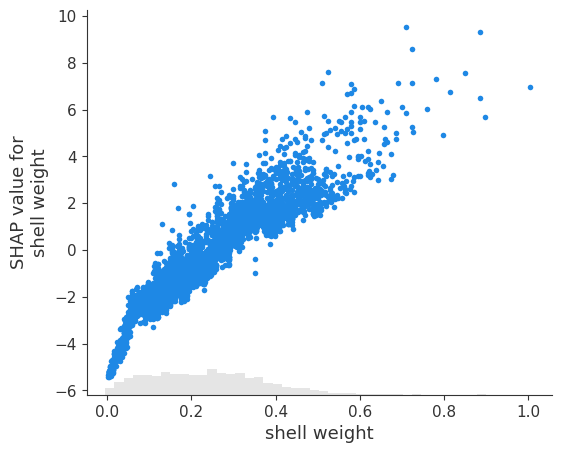

In [22]:
#Plot 1: shell weight
shap.plots.scatter(shap_values[:,"shell weight"])

We can also use the values of a second feature to colour the scatter plot. We have the same plot by now the larger the shucked weight the redder the point. We can see the SHAP values are large when both shell weight and shucked weight are large.

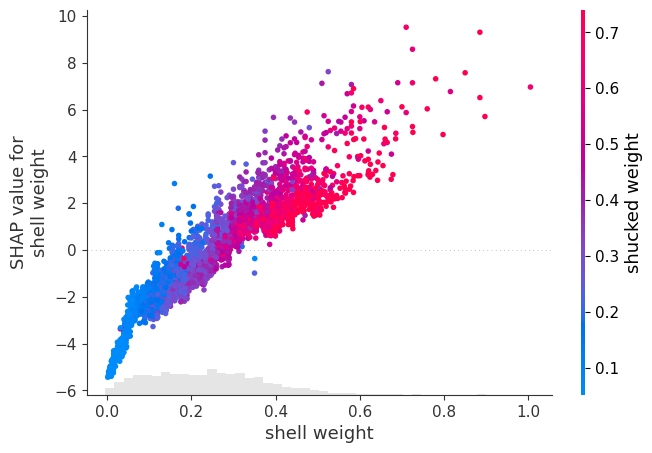

In [23]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

These plots can be used to visualise interactions between features but be cautious! In our case, the plot is a result of the correlation between the two features.

We also have the dependency plot for shucked weight (i.e the weight of the abalone meat). Using this plot we can confirm the relationship we saw in the beeswarm plot. The SHAP values do decrease as shucked weight increases.

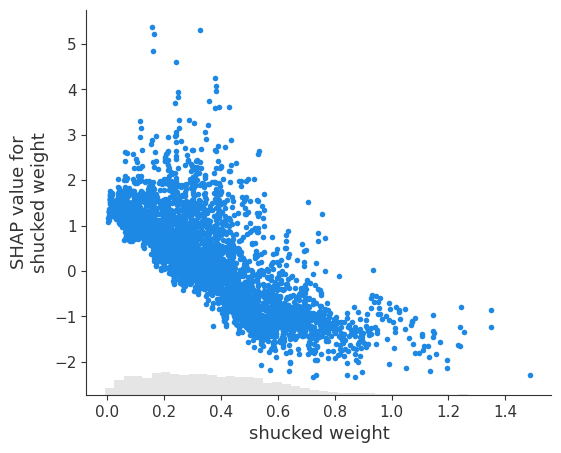

In [24]:
#Plot 2: shucked weight
shap.plots.scatter(shap_values[:,"shucked weight"])

Intuitively, this relationship may seem strange. Wouldn’t we expect older abalone to be larger and have more meat? This is, in fact, a result of an interaction between shell weight and shucked weight. We couldn’t see it in the dependence plot due to the correlation. In the article below, we explore how we can identify interactions like these using SHAP interaction values.

Author: Conor O'Sullivan <br>
Some code are adjusted by myself.